In [44]:
import numpy as np
import pandas as pd 
import holidays
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt # Visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 

from statsmodels.tsa.api import ExponentialSmoothing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

df = pd.read_csv("/kaggle/input/fetch-new/data_daily.csv")
df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


# Interpolate and expand features

In [45]:
df['Datetime'] = pd.to_datetime(pd.date_range(start='2021-01-01', end='2021-12-31'))
df = df.set_index(['Datetime'])

df['month'] = df['# Date'].apply(lambda x : int(x.split('-')[1]))
df['day'] = df['# Date'].apply(lambda x : int(x.split('-')[2]))
month_seasons = {1:"Winter", 2:"Winter",3:"Spring",4:"Spring",5:"Spring",6:"Summer",7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Winter"}
df['season'] = df['month'].apply(lambda x : month_seasons[x])

df['Date'] = pd.to_datetime(df['# Date'], format = '%Y/%m/%d')
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter

# Assuming the data is for US
df['hols'] = pd.Series(df.index).apply(lambda x: holidays.CountryHoliday('US',prov='NSW').get(x)).values

del df['# Date']
# del df['Date']

df.head()

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,hols
Datetime,,,,,,,,,
2021-01-01,7564766,1,1,Winter,2021-01-01,1,53,1,New Year's Day
2021-01-02,7455524,1,2,Winter,2021-01-02,2,53,1,None
2021-01-03,7095414,1,3,Winter,2021-01-03,3,53,1,None
2021-01-04,7666163,1,4,Winter,2021-01-04,4,1,1,None
2021-01-05,7771289,1,5,Winter,2021-01-05,5,1,1,None


Text(0, 0.5, 'receipt count')

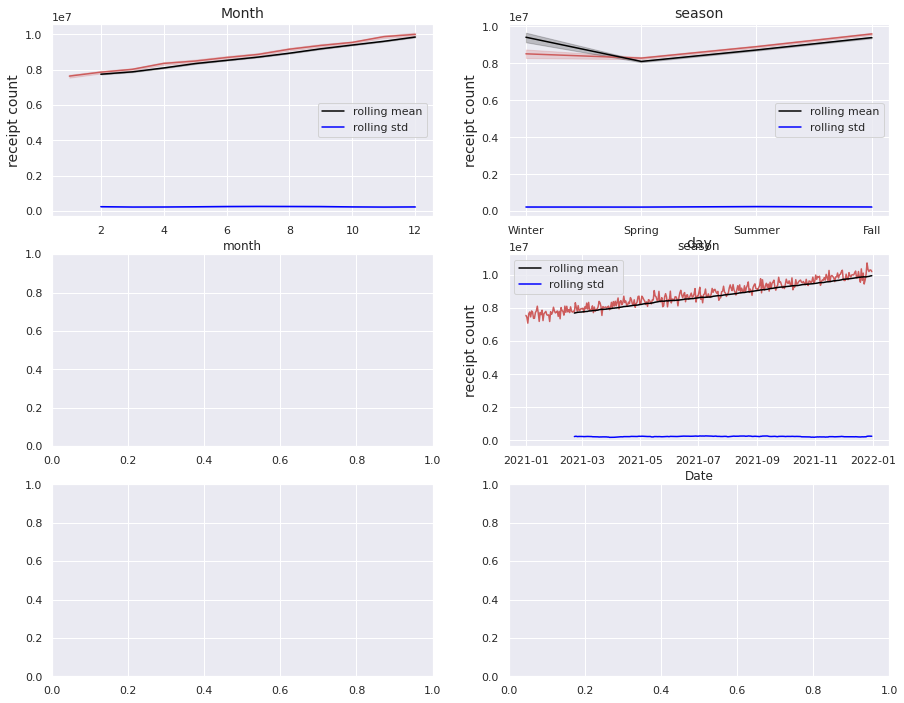

In [46]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df['Date'], y=df.Receipt_Count, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df['Date'], y=df.Receipt_Count.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df['Date'], y=df.Receipt_Count.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('day', fontsize=14)
ax[1, 1].set_ylabel(ylabel='receipt count', fontsize=14)

sns.lineplot(x=df.month, y=df.Receipt_Count, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.month, y=df.Receipt_Count.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.month, y=df.Receipt_Count.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Month', fontsize=14)
ax[0, 0].set_ylabel(ylabel='receipt count', fontsize=14)

sns.lineplot(x=df.season, y=df.Receipt_Count, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.season, y=df.Receipt_Count.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.season, y=df.Receipt_Count.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('season', fontsize=14)
ax[0, 1].set_ylabel(ylabel='receipt count', fontsize=14)


In [47]:
df

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,hols
Datetime,,,,,,,,,
2021-01-01,7564766,1,1,Winter,2021-01-01,1,53,1,New Year's Day
2021-01-02,7455524,1,2,Winter,2021-01-02,2,53,1,None
2021-01-03,7095414,1,3,Winter,2021-01-03,3,53,1,None
2021-01-04,7666163,1,4,Winter,2021-01-04,4,1,1,None
2021-01-05,7771289,1,5,Winter,2021-01-05,5,1,1,None
...,...,...,...,...,...,...,...,...,...
2021-12-27,10350408,12,27,Winter,2021-12-27,361,52,4,None
2021-12-28,10219445,12,28,Winter,2021-12-28,362,52,4,None
2021-12-29,10313337,12,29,Winter,2021-12-29,363,52,4,None


In [48]:
df.isna().sum() 

Receipt_Count      0
month              0
day                0
season             0
Date               0
day_of_year        0
week_of_year       0
quarter            0
hols             350
dtype: int64

In [49]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']
stationarity_test

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Receipt_Count,8.178773e+06,9.473738e+06,1.841813e+11,2.024817e+11
month,3.527473e+00,9.521978e+00,2.990954e+00,2.913879e+00
day,1.552198e+01,1.599451e+01,7.747741e+01,7.739776e+01
day_of_year,9.150000e+01,2.745000e+02,2.775500e+03,2.775500e+03
week_of_year,1.394505e+01,3.921429e+01,7.963232e+01,5.676598e+01
quarter,1.510989e+00,3.505495e+00,2.623095e-01,2.513509e-01


# Stationary test

In [50]:
def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)
    
    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])
    
    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Receipt_Count,"8,178,773","9,473,738","184,181,277,256","202,481,712,806"
month,4,10,3,3
day,16,16,77,77
day_of_year,92,274,"2,776","2,776"
week_of_year,14,39,80,57
quarter,2,4,0,0


In [51]:
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df.head()

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,hols
Datetime,,,,,,,,,
2021-01-01,7564766,1,1,Winter,2021-01-01,1,53,1,New Year's Day
2021-01-02,7455524,1,2,Winter,2021-01-02,2,53,1,None
2021-01-03,7095414,1,3,Winter,2021-01-03,3,53,1,None
2021-01-04,7666163,1,4,Winter,2021-01-04,4,1,1,None
2021-01-05,7771289,1,5,Winter,2021-01-05,5,1,1,None


In [52]:
df = df.sort_values(by='Receipt_Count', ascending=False)
print(df.head())
df = df.sort_values(by='Date', ascending=True)


            Receipt_Count  month  day  season       Date  day_of_year  \
Datetime                                                                
2021-12-26       10738865     12   26  Winter 2021-12-26          360   
2021-12-20       10379305     12   20  Winter 2021-12-20          354   
2021-12-27       10350408     12   27  Winter 2021-12-27          361   
2021-12-29       10313337     12   29  Winter 2021-12-29          363   
2021-12-30       10310644     12   30  Winter 2021-12-30          364   

            week_of_year  quarter  hols  
Datetime                                 
2021-12-26            51        4  None  
2021-12-20            51        4  None  
2021-12-27            52        4  None  
2021-12-29            52        4  None  
2021-12-30            52        4  None  


Text(0, 0.5, 'Receipt count')

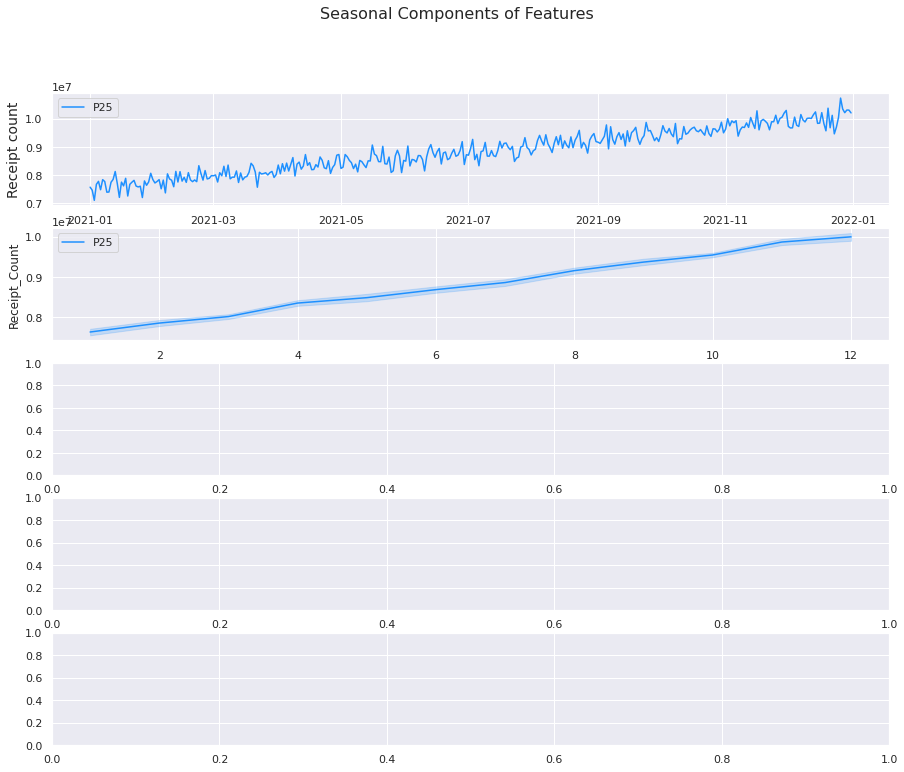

In [53]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=df.Date, y=df.Receipt_Count
             , ax=ax[0], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Receipt count', fontsize=14)

f.suptitle('Seasonal Components of Features', fontsize=16)
sns.lineplot(x=df.month, y=df.Receipt_Count
             , ax=ax[1], color='dodgerblue', label='P25')
ax[0].set_ylabel(ylabel='Receipt count', fontsize=14)

In [54]:
df.head()

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,hols
Datetime,,,,,,,,,
2021-01-01,7564766,1,1,Winter,2021-01-01,1,53,1,New Year's Day
2021-01-02,7455524,1,2,Winter,2021-01-02,2,53,1,None
2021-01-03,7095414,1,3,Winter,2021-01-03,3,53,1,None
2021-01-04,7666163,1,4,Winter,2021-01-04,4,1,1,None
2021-01-05,7771289,1,5,Winter,2021-01-05,5,1,1,None


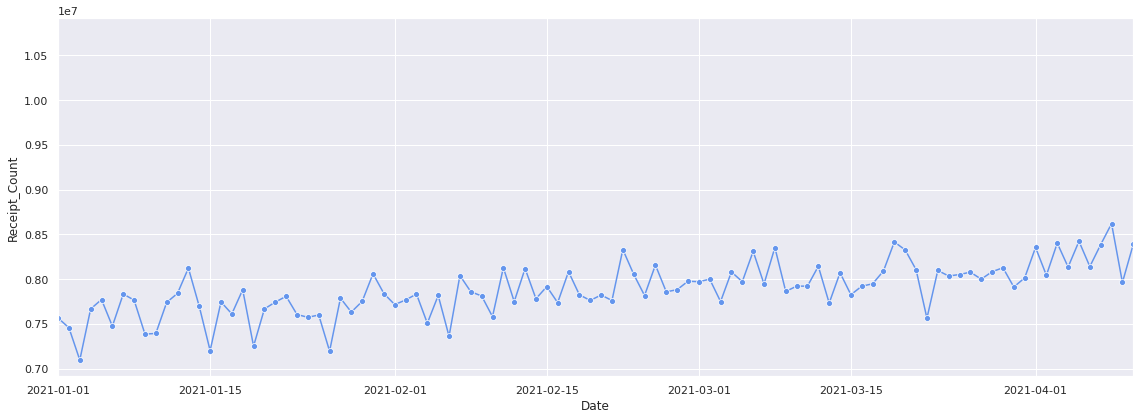

In [55]:
### Visualize time series ###
sns.lineplot(x=df.Date, y=df.Receipt_Count, color='cornflowerblue', marker='o').set_xlim([date(2021, 1, 1), date(2021, 4, 10)])
plt.tight_layout()
plt.show()


In [56]:
df['Datetime'] = pd.to_datetime(pd.date_range(start='2021-01-01', end='2021-12-31'))
df = df.set_index(['Datetime'])
df.head()

,Receipt_Count,month,day,season,Date,day_of_year,week_of_year,quarter,hols
Datetime,,,,,,,,,
2021-01-01,7564766,1,1,Winter,2021-01-01,1,53,1,New Year's Day
2021-01-02,7455524,1,2,Winter,2021-01-02,2,53,1,None
2021-01-03,7095414,1,3,Winter,2021-01-03,3,53,1,None
2021-01-04,7666163,1,4,Winter,2021-01-04,4,1,1,None
2021-01-05,7771289,1,5,Winter,2021-01-05,5,1,1,None


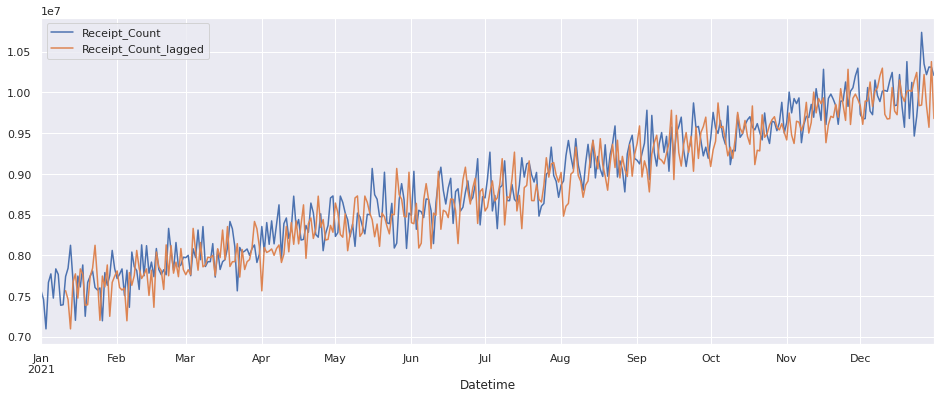

In [57]:
df["Receipt_Count"].asfreq('D').plot(legend=True)
shifted = df["Receipt_Count"].asfreq('D').shift(10).plot(legend=True)
shifted.legend(['Receipt_Count','Receipt_Count_lagged'])
plt.show()

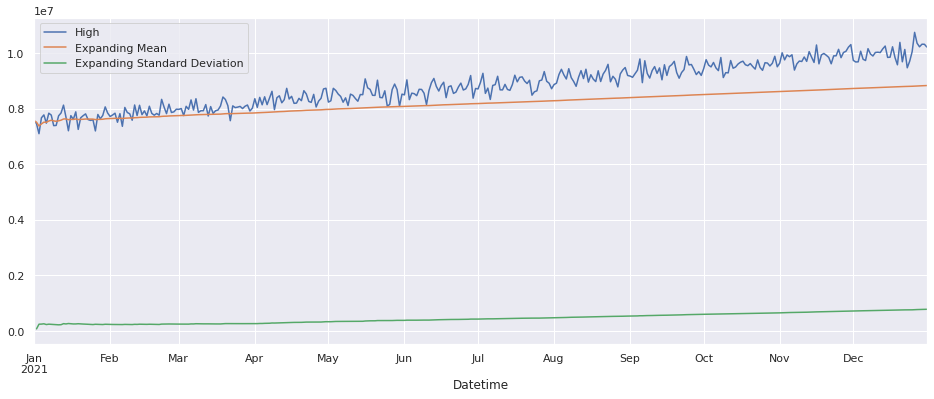

In [58]:
microsoft_mean = df.Receipt_Count.expanding().mean()
microsoft_std = df.Receipt_Count.expanding().std()
df.Receipt_Count.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation'])
plt.show()

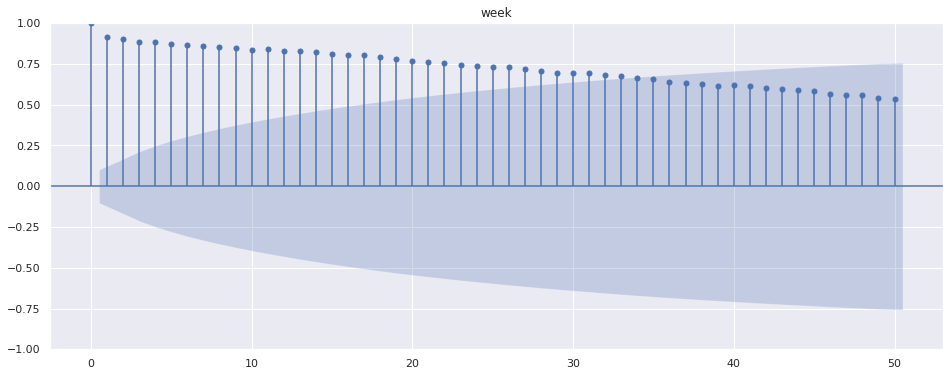

In [61]:
plot_acf(df["Receipt_Count"],lags=50,title="week")
plt.show()

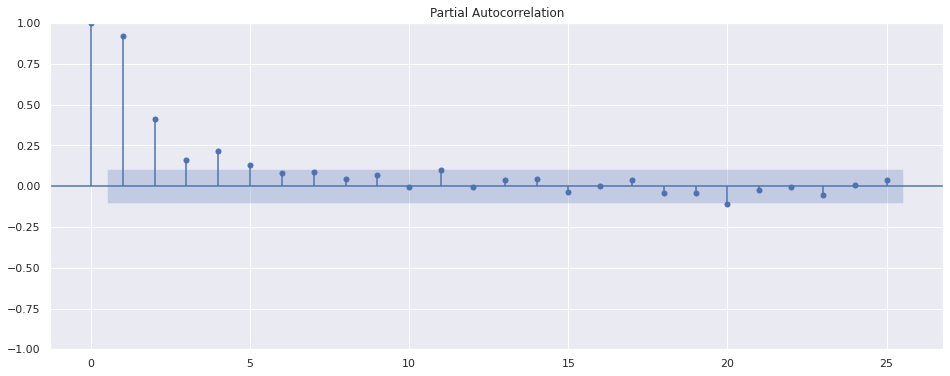

In [62]:
# Partial Autocorrelation of humidity of San Diego
plot_pacf(df["Receipt_Count"],lags=25)
plt.show()

In [63]:

adf = adfuller(df["Receipt_Count"])
print("p-value of Receipt_Count: {}".format(float(adf[1])))

p-value of Receipt_Count: 0.9708266454651425


In [64]:

rcParams['figure.figsize'] = 16, 6
model = ARIMA(df["Receipt_Count"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5147.124
Date:                Sun, 05 Feb 2023   AIC                          10300.249
Time:                        19:02:57   BIC                          10311.932
Sample:                             0   HQIC                         10304.893
                                - 364                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9582      0.049    -19.734      0.000      -1.053      -0.863
ar.L2         -0.4224      0.046     -9.227      0.000      -0.512      -0.333
sigma2      1.204e+11   1.32e-14   9.15e+24      0.0

### building the model

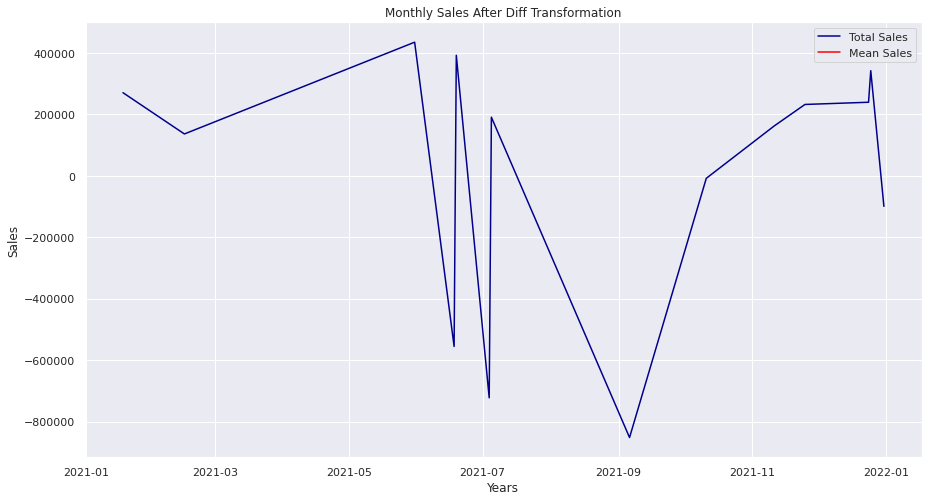

In [65]:


def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x_col, y_col, data = data, ax = ax, color = 'darkblue', label='Total Sales')
    
    s_mean = data.groupby(data.index.year)[y_col].mean().reset_index()
    s_mean.Datetime = pd.to_datetime(s_mean.Datetime, format='%Y')
    sns.lineplot((s_mean.Datetime + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)
    
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['Receipt_Count_diff'] = data.Receipt_Count.diff()
    data = data.dropna()
    
    return data

stationary_df = get_diff(df)
time_plot(stationary_df, 'Datetime', 'Receipt_Count_diff', 'Monthly Sales After Diff Transformation')

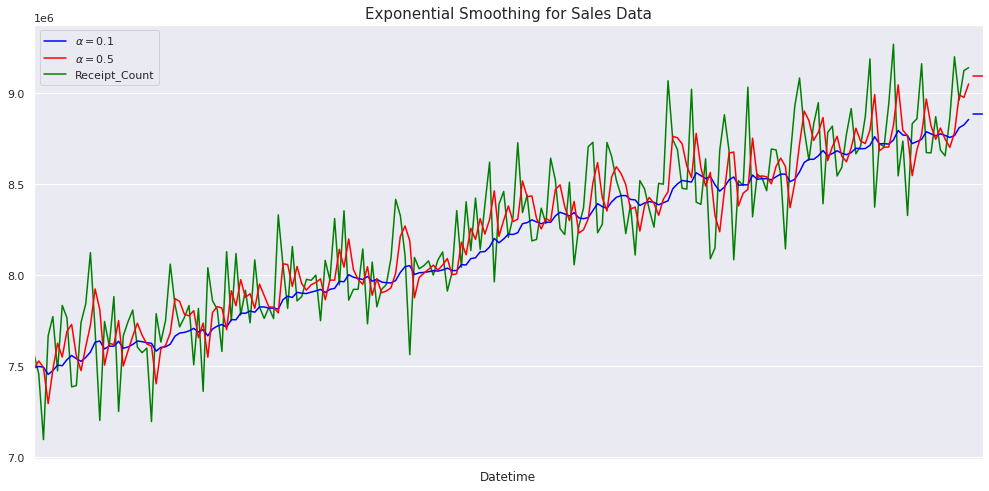

In [66]:


fit1 = ExponentialSmoothing(df["Receipt_Count"][0:200]).fit(smoothing_level=0.1, optimized=False)
fit2 = ExponentialSmoothing(df["Receipt_Count"][0:200]).fit(smoothing_level=0.5, optimized=False)
forecast1 = fit1.forecast(3).rename(r'$\alpha=0.1$')
forecast2 = fit2.forecast(3).rename(r'$\alpha=0.5$')
plt.figure(figsize=(17,8))

forecast1.plot(color='blue', legend=True)
forecast2.plot(color='red', legend=True)
df["Receipt_Count"][0:200].plot(marker='',color='green', legend=True)
fit1.fittedvalues.plot(color='blue')
fit2.fittedvalues.plot(color='red')
plt.title("Exponential Smoothing for Sales Data", fontsize=15)
plt.xticks([])

plt.show()